### Connecting packages

In [1]:
import pandas as pd
import time
import torch
import numpy as np
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import sys
sys.path.append('../')

from edge_predict.Evaluator import Evaluator
from edge_predict.LinkPrediction import LinkPrediction
from edge_predict.KGEModel import KGEModel
from edge_predict.KGEDataset import InfoData
from data.RandomData import RandomData
from cluster_latent.Cluster import Cluster

### Definition of hyperparameters

In [2]:
EPOCH = 100
BATCH_SIZE = 10
BATCH_SIZE_TEST = 10
VALIDATION_INTERVAL = 5
EMBEDDING_SIZE = 10
GAMMA = 12
LEARNING_RATE = 0.0001
REGULARIZATION = 0
ADVERSARIAL_TEMPERATURE  = 1 #In self-adversarial sampling, we do not apply back-propagation on the sampling weight
NUM_WORKERS = 10
UNI_WEIGHT = True

NAME_PATH = 'log//'+ time.ctime()
NAME_PATH = 'trash'
if not os.path.exists(NAME_PATH): os.makedirs(NAME_PATH)

### Loading data
The data must be in the form of Pandas DataFrames of a certain structure. The names of the columns for the train, test and valid dataset are
- head
- relation
- tail
- neg_head
- neg_tail 

and for the train complement 
- subsampling_weight


<font color='brown'><b>head</b></font> and <font color='brown'><b>tail</b></font> are graph entities. For example, the head can be user ids, and the tail can be store ids.   
All id's must be reindexed and are in the range <font color='royalblue'><b>[0, len( set( head | tail ))]</b></font>

<font color='brown'><b>relation</b></font> is a link between entities. For example, between a customer and a store, between a store and a category, etc.   
All relations must be reindexed and are in range <font color='royalblue'><b>[0, len( set( relation ))]</b></font>

<font color='brown'><b>neg_head</b></font> is a list of negative samples from the head indices for tail and relation in the given row. That is, those heads which not link with tail.

<font color='brown'><b>neg_tail</b></font> is a list of negative samples from the tail indices for head and relation in the given row. That is, those tails which not link with head.

<font color='brown'><b>subsampling_weight</b></font> shows how many identical connections in the entire sample.   
You can use any available formulas to calculate this parameter, or see the calculation in `data.RandomData`.

--

As an example, random dataset values are generated using the `RandomData()` module.

You can also use your own data loading, such as csv format, using the following code:  

```
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
valid = pd.read_csv('data/valid.csv')

for i in [train, valid, test]:
     i['neg_head'] = [eval(l) for l in i['neg_head']]
     i['neg_tail'] = [eval(l) for l in i['neg_tail']]
```

Please, before loading the data into the model, check it for correctness using `test.TestData`.

In [3]:
train,test,valid = RandomData().get_data()
nentity,nrelation, v_tr, v_val, v_test, info = InfoData(train,test,valid).get_data()
print(info)

100%|██████████| 300/300 [00:00<00:00, 36431.03it/s]

 NUMBER OF ENTITY: 130 
 NUMBER OF RELETION: 2 
 TRAIN: 76% 
 VALID: 5% 
 TEST: 19%


### Model training and its metrics

Now let's train the model on the loaded data. All parameters (loss, metrics, as well as the model itself) can be found in the 'log / *start date*' directory. It is worth saying that the metrics show low values, because we generated a sample randomly.

Training...


100%|██████████| 100/100 [01:45<00:00,  1.05s/it]

Testing...


Metrics: {'MRR': 0.16957569122314453, 'HITS@1': 0.0625, 'HITS@3': 0.11250000447034836, 'HITS@10': 0.42500004172325134}
Saving...


<Figure size 432x288 with 0 Axes>

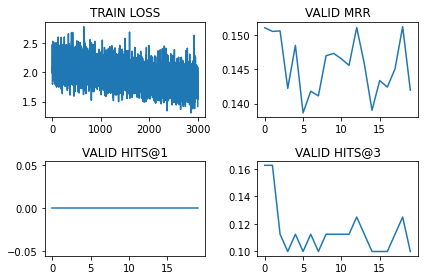

In [4]:
MODEL_NAME = 'TransE'
evaluator = Evaluator() 
kge_model = KGEModel(model_name = MODEL_NAME, nentity=nentity, nrelation=nrelation,
                    embedding_size=EMBEDDING_SIZE, gamma=GAMMA, evaluator=evaluator)
model = LinkPrediction(kge_model)
model.run(train,test,valid,REGULARIZATION,LEARNING_RATE,EPOCH,BATCH_SIZE,NUM_WORKERS,ADVERSARIAL_TEMPERATURE,MODEL_NAME,NAME_PATH, BATCH_SIZE_TEST, UNI_WEIGHT, VALIDATION_INTERVAL)

### Usage example

Now let's imagine that we trained our model on the users-shops graph. You can display a ranked list of stores where the user will buy based on past purchases.

In [5]:
user = 0
all_shop = list(set(train['tail']))
model.kge_model.cpu()
prediction = model.kge_model(torch.tensor(user), torch.tensor(0), torch.tensor(0), 
                                                torch.tensor([[0]]), torch.tensor([all_shop]))[1][0]
sort_prediction, sort_shop = zip(*[(b, a) for b, a in sorted(zip(prediction, all_shop), reverse=True)])
print('Top 10 stores where the user will buy:', sort_shop[:10])

Top 10 stores where the user will buy: (115, 119, 122, 106, 128, 103, 123, 113, 126, 100)


### Clustering

Now you can analyze entities using clustering. To do this, use method `cluster_latent.Claster`. Load the necessary embeddings into it. By default, embeddings will be colored by k_means. If you want to color differently load your labels into the method.

This result turned out as such, since the method was applied to random data.

/data/home/eegorova/.conda/envs/ml/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/data/home/eegorova/.conda/envs/ml/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/data/home/eegorova/.conda/envs/ml/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


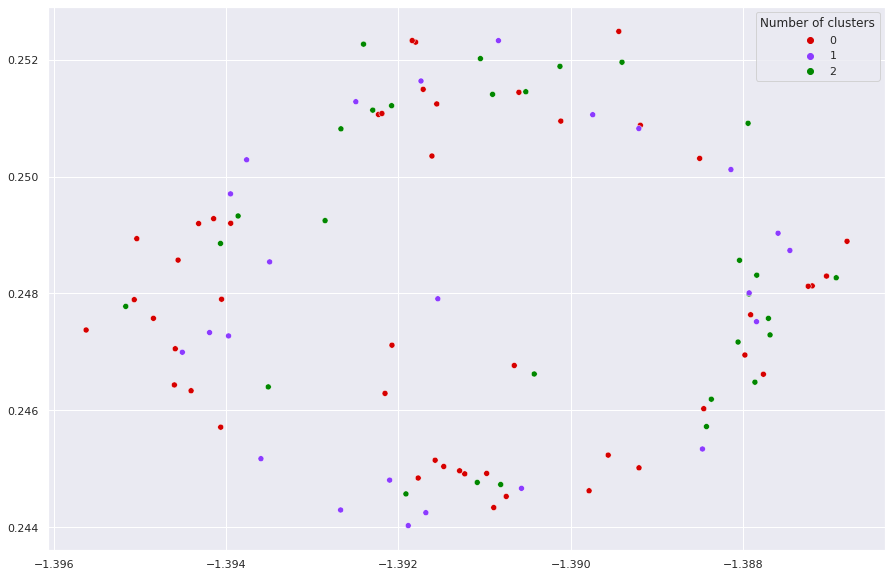

In [6]:
model_dict = torch.load(NAME_PATH+'//'+ MODEL_NAME + '//'+'model.pt', map_location="cuda:1")
cust_embed = model_dict['entity_embedding'][:100]
cluster = Cluster(data_path=NAME_PATH+'//'+ MODEL_NAME, embeddings=cust_embed, NUM_CLUSTERS = 3)
cluster.TSNE()

### Examples of clustering on real data

Data: user purchases in the store.   
As labels, various data was loaded, such as the popular shopping area from the user, the popular category, etc.

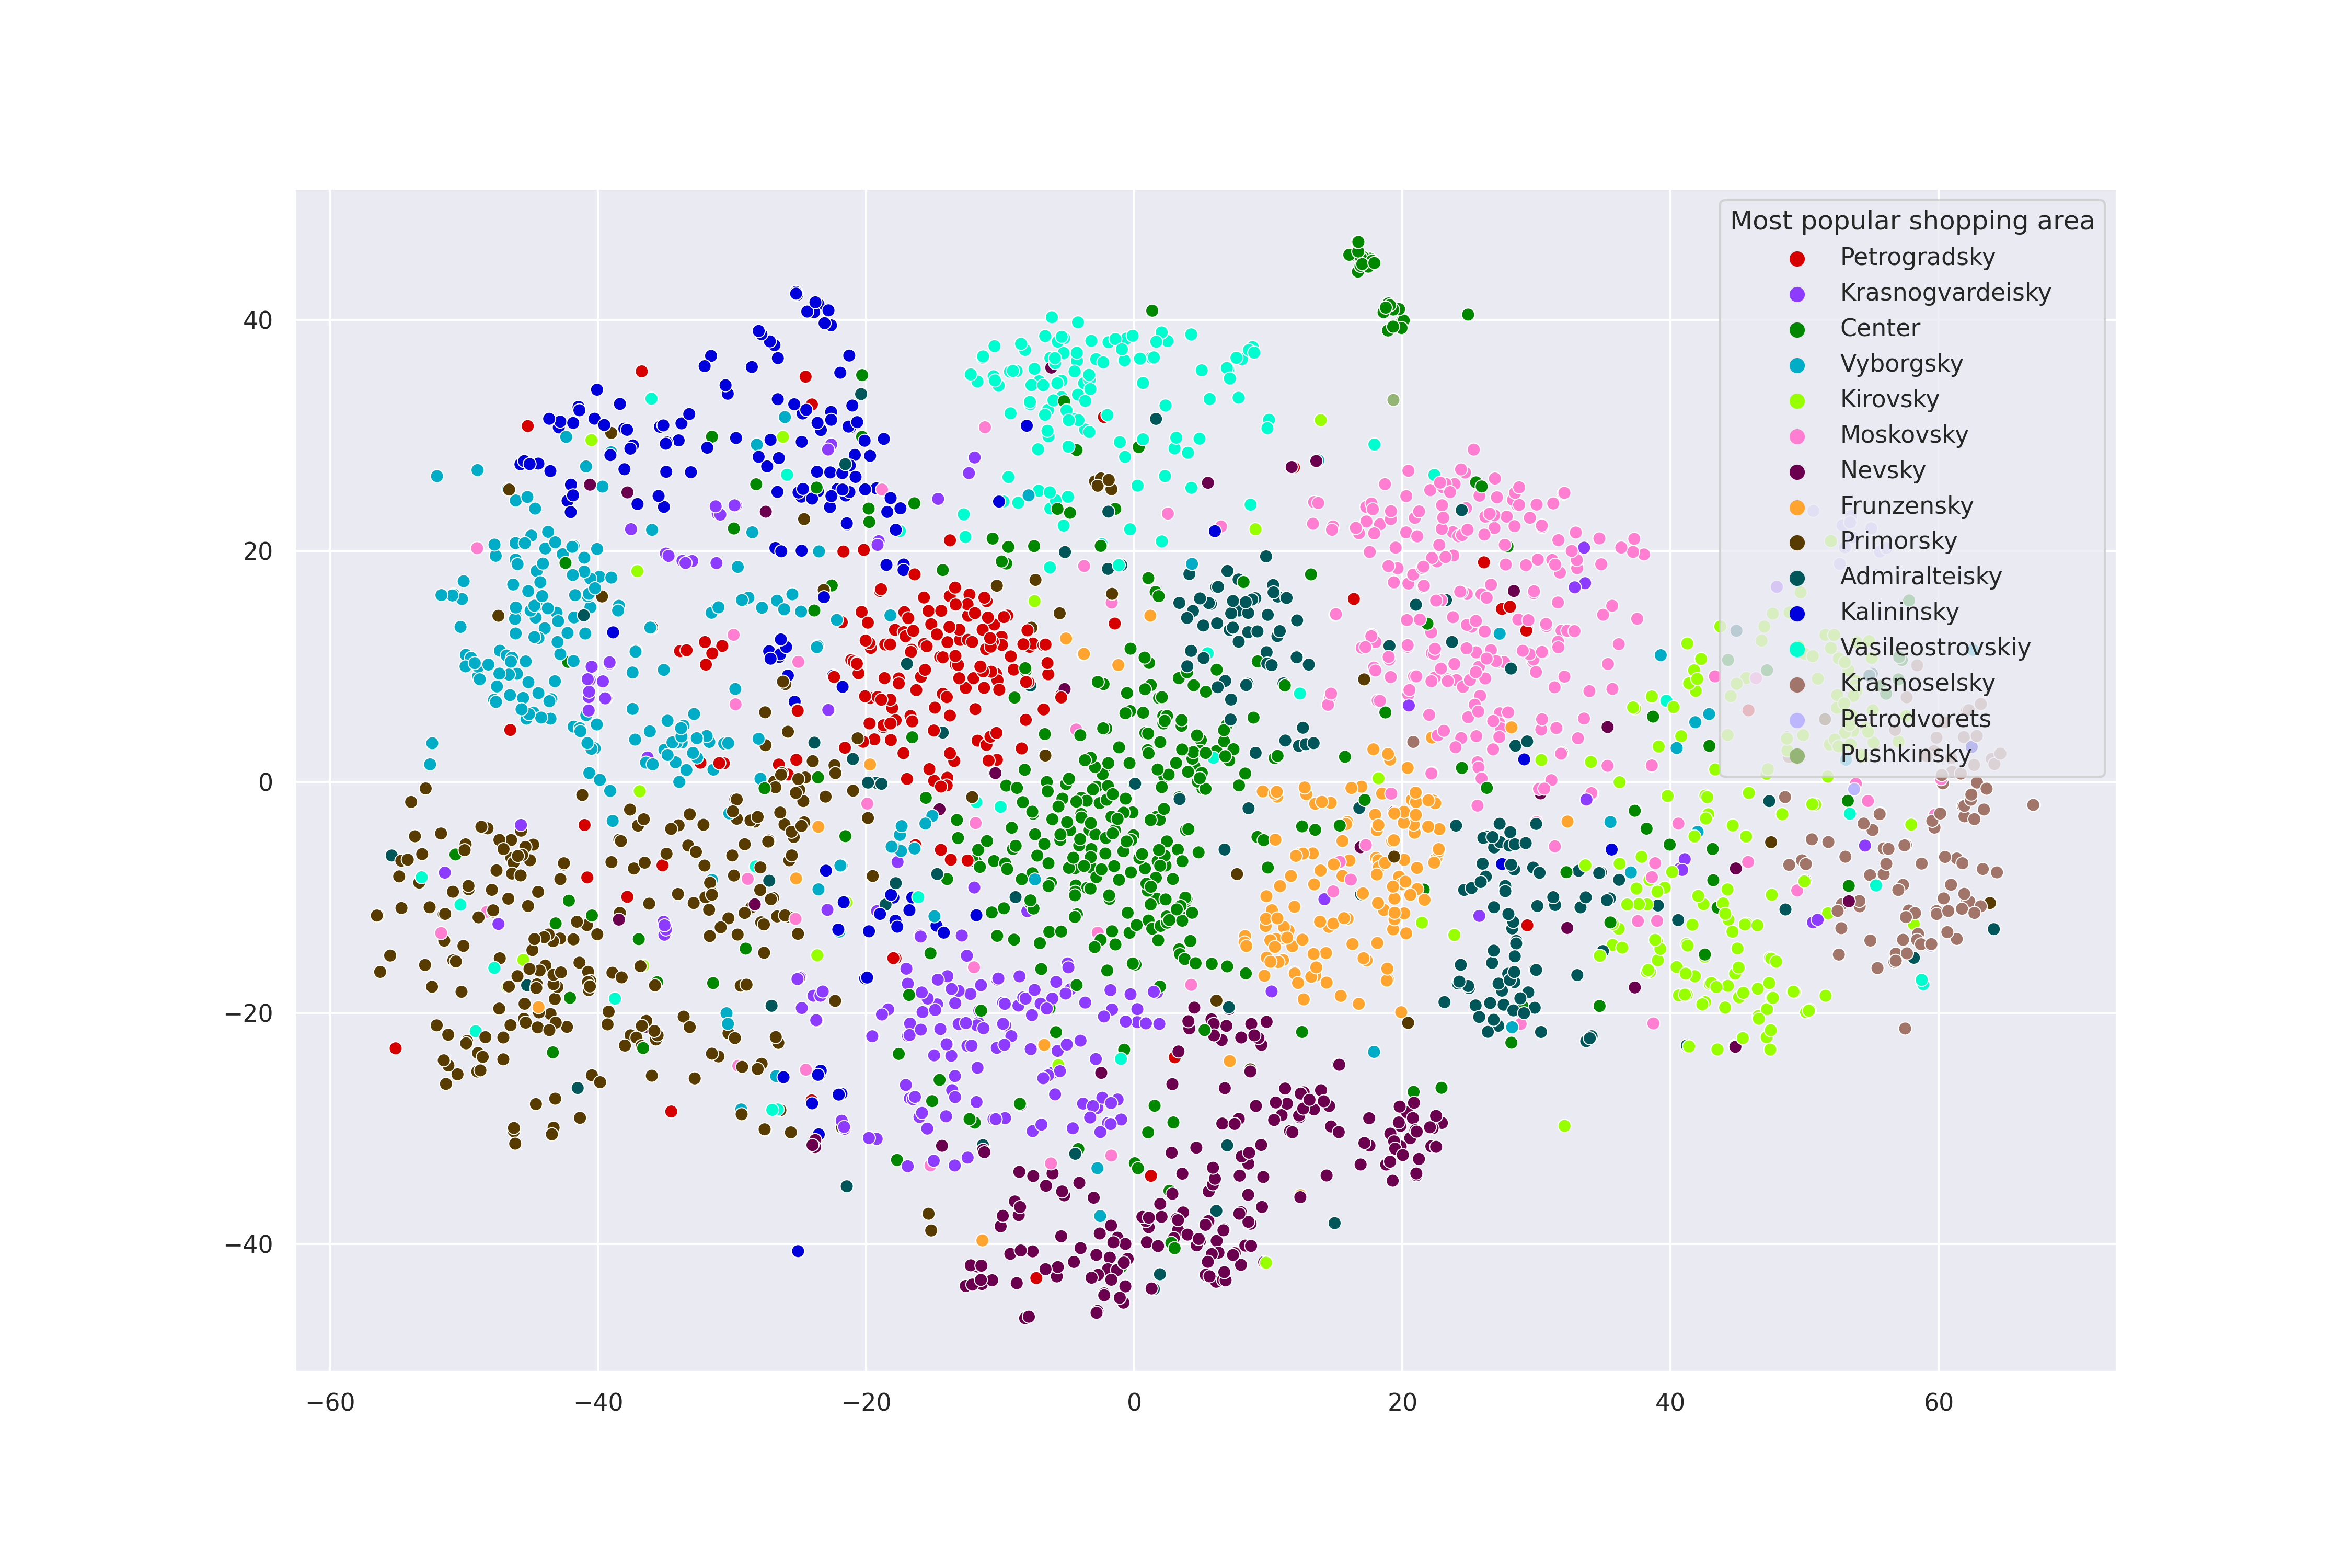

In [7]:
from PIL import Image
img = Image.open(r'log/example/TransE/clustering/district.png')
img.show()

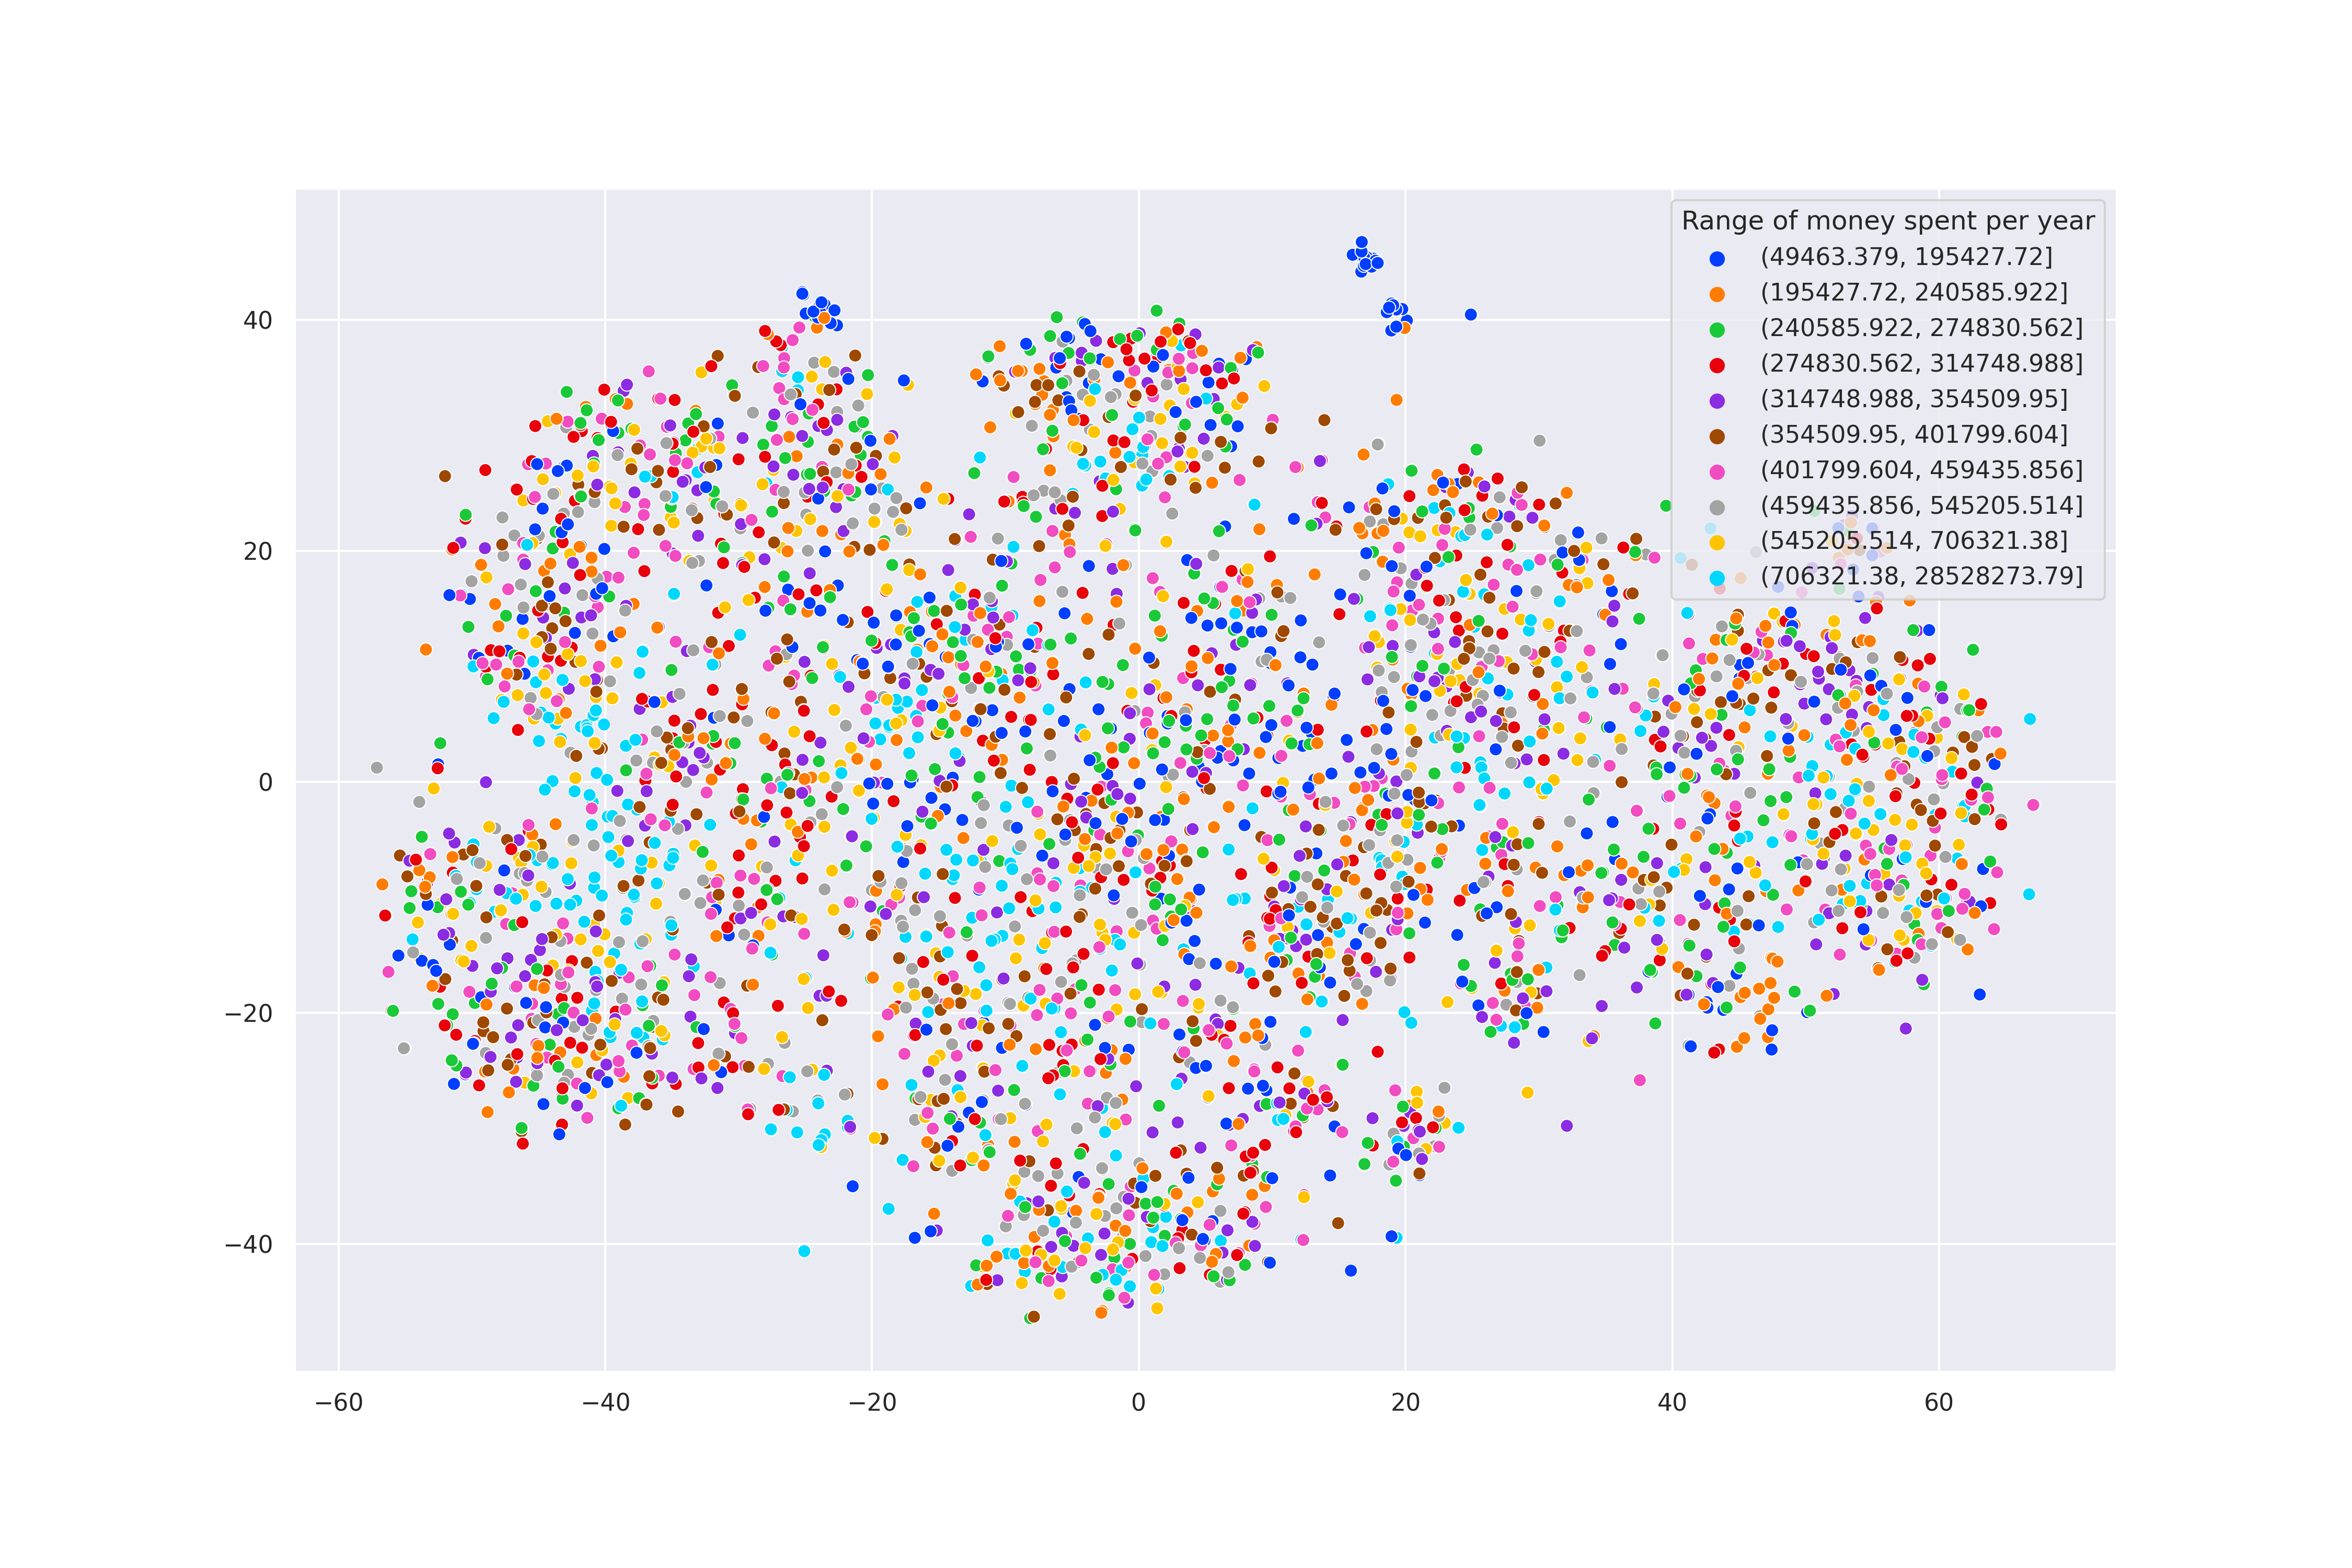

In [8]:
img = Image.open(r'log/example/TransE/clustering/money_spent.png')
img.show()

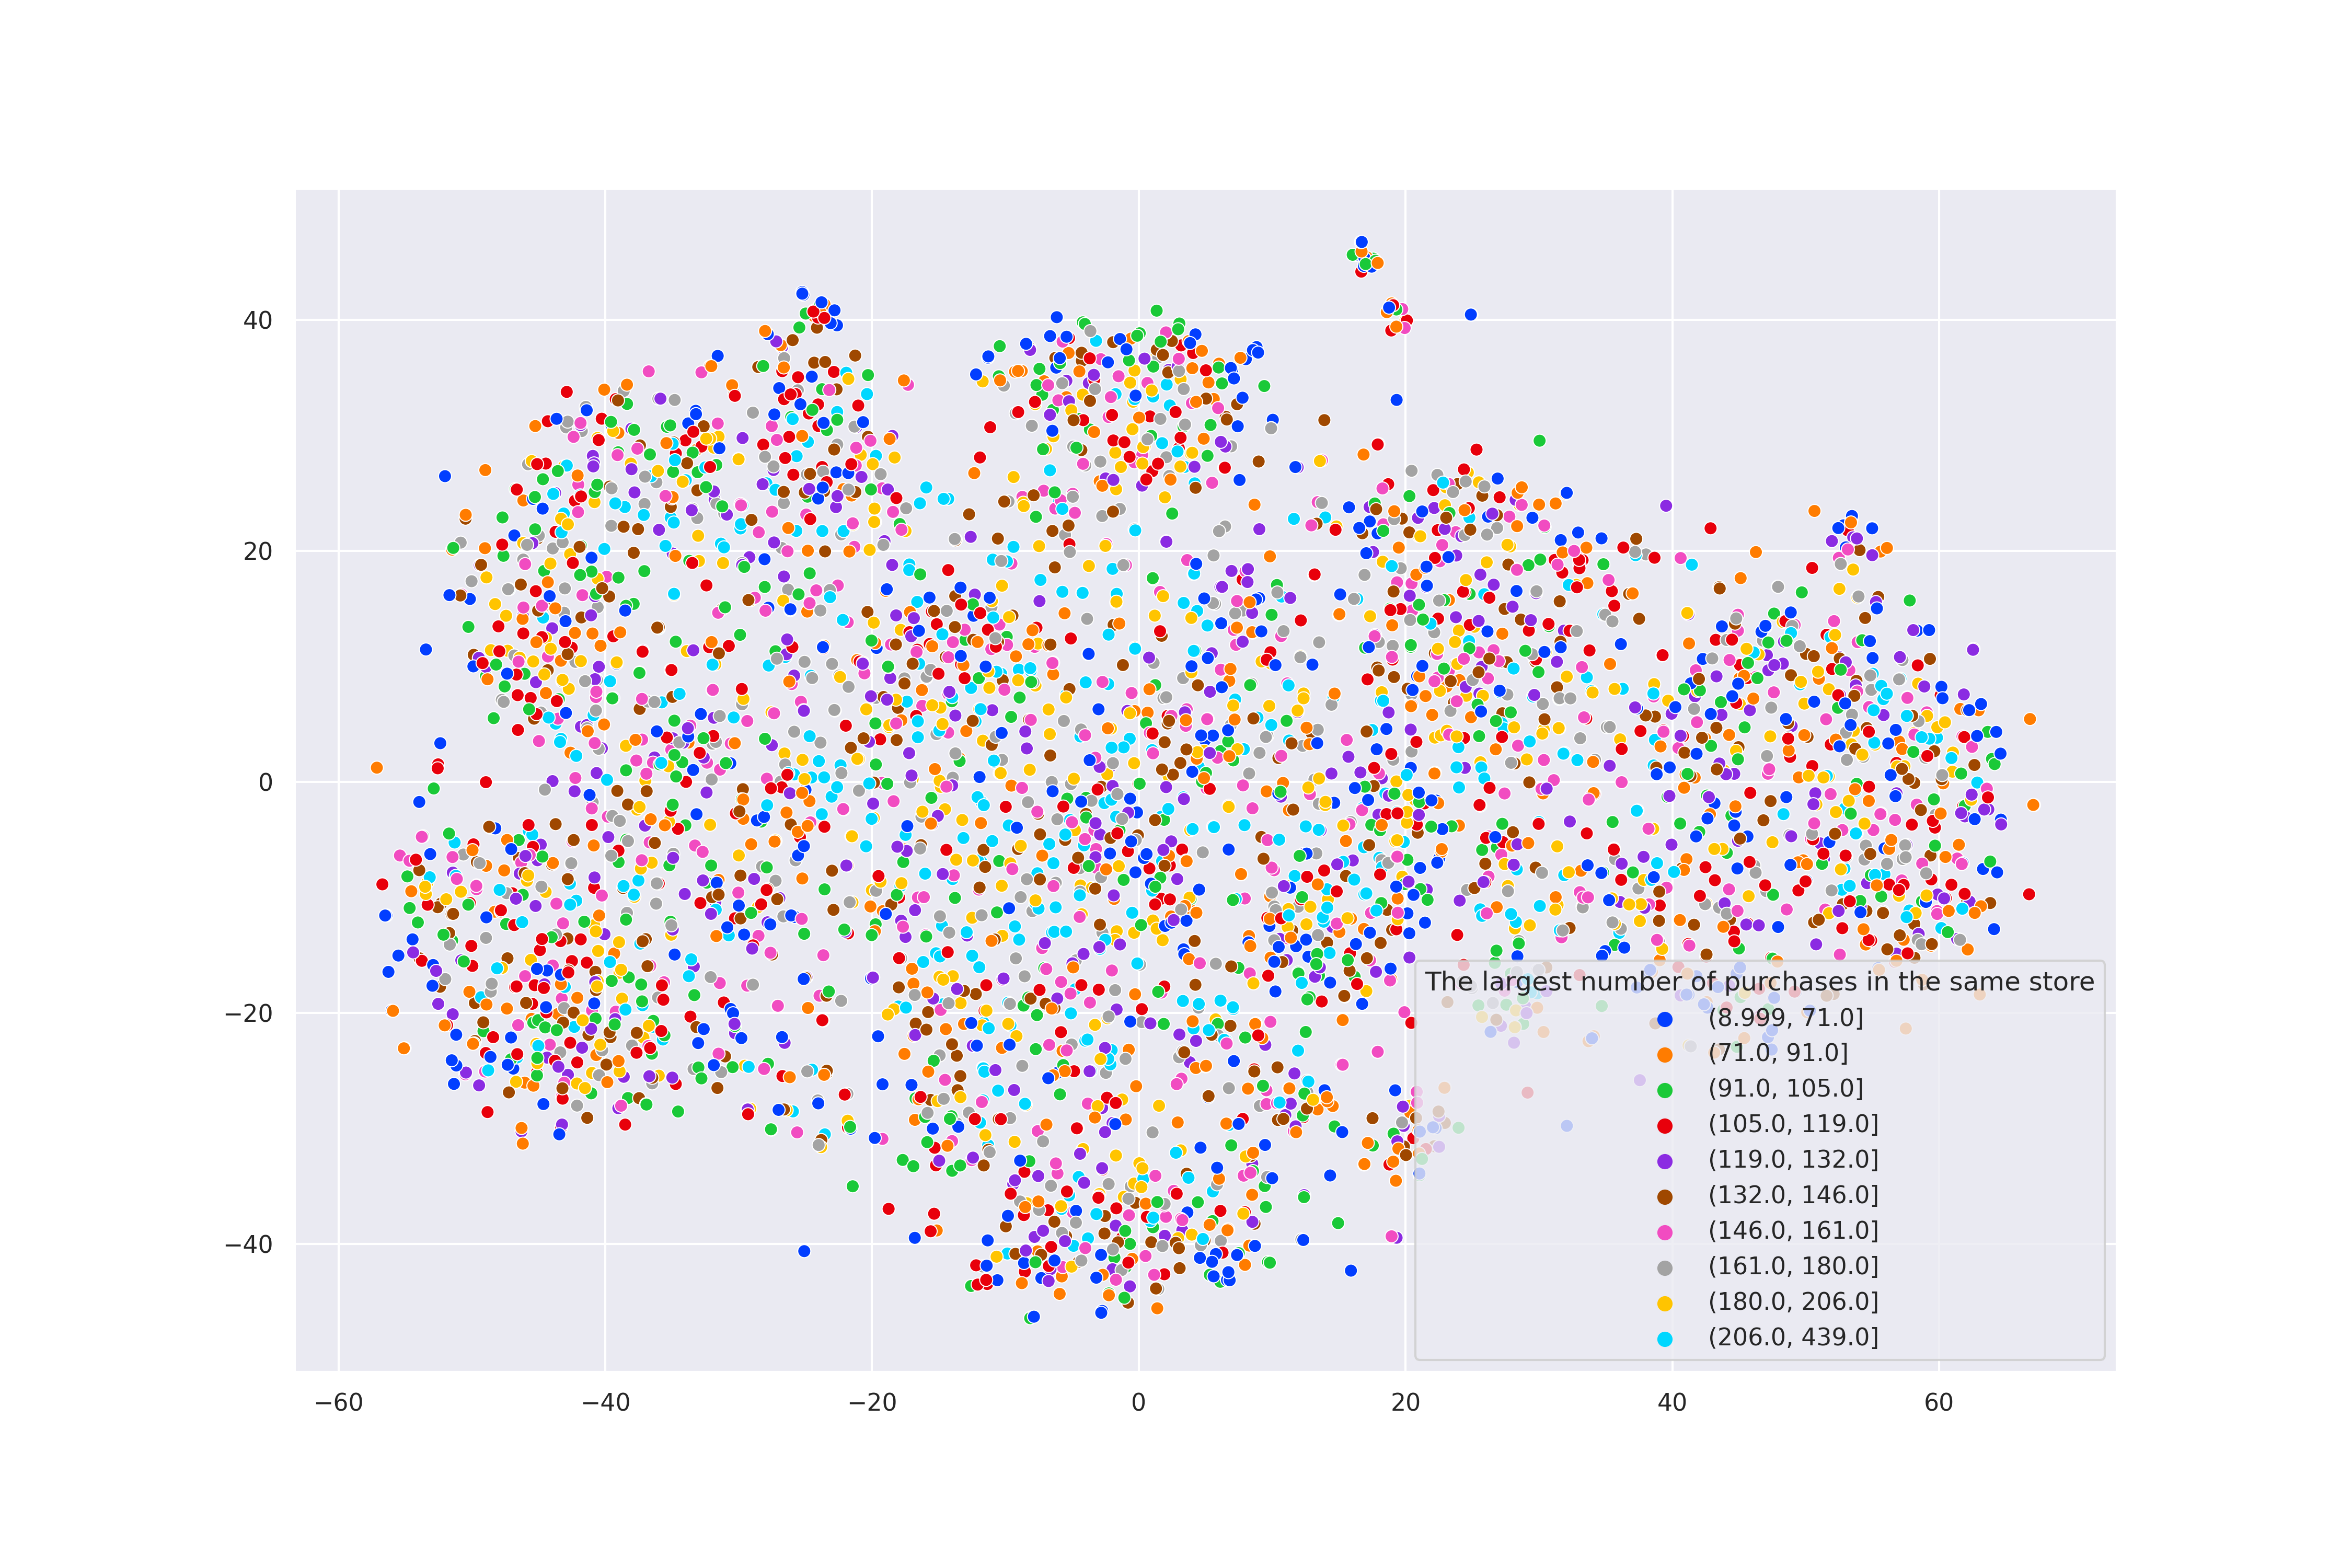

In [9]:
img = Image.open(r'log/example/TransE/clustering/stability.png')
img.show()